# Topic Modeling: Latent Semantic Analysis/Indexing

Latent Semantic Analysis set out to improve the results of queries that omitted relevant documents containing synonyms of query terms. Its aimed to model the relationships between documents and terms to be able to predict that a term should be associated with a document, even though, because of variability in word use, no such association was observed.

LSI uses linear algebra to find a given number k of latent topics by decomposing the DTM. More specifically, it uses the Singular Value Decomposition (SVD) to find the best lower-rank DTM approximation using k singular values & vectors. In other words, LSI is an application of the unsupervised learning techniques of dimensionality reduction we encountered in chapter 12 (with some additional detail). The authors experimented with hierarchical clustering but found it too restrictive to explicitly model the document-topic and topic-term relationships or capture associations of documents or terms with several topics.

## Imports & Settings

In [2]:
import warnings
from collections import OrderedDict
from pathlib import Path
from random import randint
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

In [4]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14.0, 8.7)
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

## Load BBC data

We will illustrate the application of LSI using the BBC articles data that we introduced in the last chapter because they are both small to permit quick training and allow us to compare topic assignments to category labels.

In [5]:
# change to your data path if necessary
DATA_DIR = Path('../data')

In [13]:
path = DATA_DIR / 'bbc'
files = path.glob('**/*.txt')
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        topic = file.parts[-2]
        lines = f.readlines()
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic.capitalize(), heading, body])

### Convert to DataFrame

In [14]:
docs = pd.DataFrame(doc_list, columns=['Category', 'Heading', 'Article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
Category    2225 non-null object
Heading     2225 non-null object
Article     2225 non-null object
dtypes: object(3)
memory usage: 52.2+ KB


## Create Train & Test Sets

We begin by loading the documents and creating a train and (stratified) test set with 50 articles. Then, we vectorize the data using the TfidfVectorizer to obtain weighted DTM counts and filter out words that appear in less than 1% or more than 25% of the documents as well as generic stopwords to obtain a vocabulary of around 2,900 words:

In [16]:
train_docs, test_docs = train_test_split(docs, 
                                         stratify=docs.Category, 
                                         test_size=50, 
                                         random_state=42)

In [17]:
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [18]:
pd.Series(test_docs.Category).value_counts()

Sport            12
Business         11
Politics          9
Tech              9
Entertainment     9
Name: Category, dtype: int64

### Vectorize train & test sets

In [19]:
vectorizer = TfidfVectorizer(max_df=.25, min_df=.01, stop_words='english', binary=False)
train_dtm = vectorizer.fit_transform(train_docs.Article)
train_dtm

<2175x2909 sparse matrix of type '<class 'numpy.float64'>'
	with 209745 stored elements in Compressed Sparse Row format>

In [20]:
test_dtm = vectorizer.transform(test_docs.Article)
test_dtm

<50x2909 sparse matrix of type '<class 'numpy.float64'>'
	with 4876 stored elements in Compressed Sparse Row format>

### Get token count

In [21]:
train_token_count = train_dtm.sum(0).A.squeeze()
tokens = vectorizer.get_feature_names()
word_count = pd.Series(train_token_count, index=tokens).sort_values(ascending=False)
word_count.head(10)

film         41.33
government   38.70
game         36.18
uk           35.99
best         35.93
labour       32.90
music        30.94
000          30.26
company      29.81
number       28.59
dtype: float64

## Latent Semantic Analysis

We use sklearn’s TruncatedSVD class that only computes the k largest singular values to reduce the dimensionality of the document-term matrix. The deterministic arpack algorithm delivers an exact solution but the default ‘randomized’ implementation is more efficient for large matrices. 

We compute five topics to match the five categories, which explain only 5.4% of the total DTM variance so higher values would be reasonable.

In [22]:
n_components = 5
topic_labels = ['Topic {}'.format(i) for i in range(1, n_components+1)]

In [23]:
svd = TruncatedSVD(n_components=n_components, 
                   n_iter=5, 
                   random_state=42)
svd.fit(train_dtm)

TruncatedSVD(algorithm='randomized', n_components=5, n_iter=5,
       random_state=42, tol=0.0)

In [24]:
svd.singular_values_

array([8.92087786, 5.7345608 , 5.40534764, 5.05164377, 4.73209665])

In [28]:
svd.explained_variance_ratio_.sum()

0.0541882619889292

### Explore Topics 

LSI identifies a new orthogonal basis for the document-term matrix that reduces the rank to the number of desired topics. 

The `.transform()` method of the trained svd object projects the documents into the new topic space that is the result of reducing the dimensionality of the document vectors and corresponds to the UTΣT transformation explained in the book.

In [26]:
train_doc_topics = svd.transform(train_dtm)

In [27]:
train_doc_topics.shape

(2175, 5)

#### Topic Weights for sample article

We can sample an article to view its location in the topic space. We draw a ‘Politics’ article that is most (positively) associated with topics 1 and 2 (and 3):

In [37]:
i = randint(0, len(train_docs))
(train_docs.iloc[i, :2].append(pd.Series(train_doc_topics[i], 
                                         index=topic_labels)))

Category                             Politics
Heading     UK heading wrong way, says Howard
Topic 1                                  0.28
Topic 2                                  0.25
Topic 3                                  0.19
Topic 4                                  0.04
Topic 5                                  0.04
dtype: object

#### Average topic weight per category

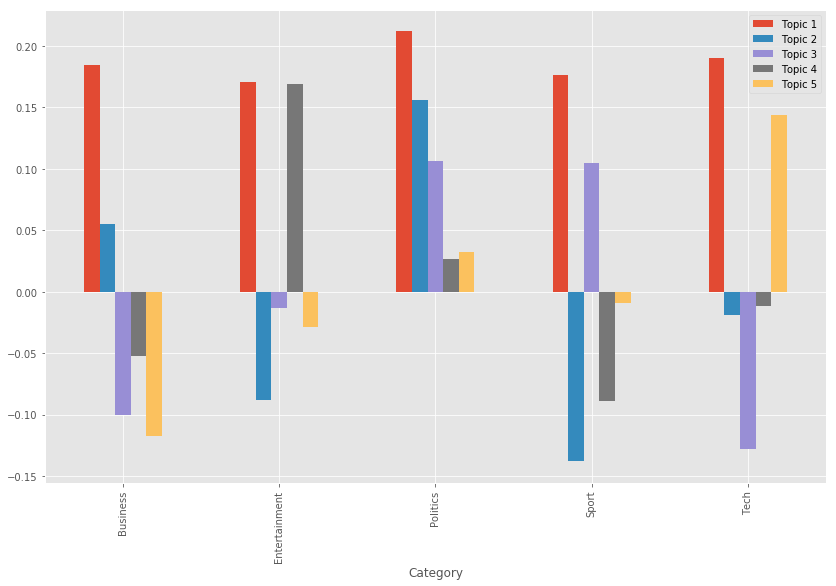

In [170]:
train_result = pd.DataFrame(data=doc_topics,
                   columns=topic_labels,
                   index=train_docs.Category)
train_result.groupby(level='Category').mean().plot.bar();

#### Topics weights of most frequent words

In [108]:
topics = pd.DataFrame(svd.components_.T,
                      index=tokens,
                      columns=topic_labels)
topics.loc[word_count.head(10).index]

Topic 1  Topic 2  Topic 3  Topic 4  Topic 5
film           0.10    -0.15    -0.02     0.46    -0.11
government     0.11     0.16     0.04    -0.00    -0.03
game           0.09    -0.16     0.08    -0.11     0.06
uk             0.09     0.03    -0.06     0.04     0.02
best           0.09    -0.14     0.03     0.27    -0.09
labour         0.10     0.25     0.21     0.07     0.06
music          0.08    -0.06    -0.11     0.08     0.14
000            0.07     0.03    -0.05     0.00    -0.01
company        0.07     0.02    -0.10    -0.03    -0.06
number         0.07    -0.04    -0.02     0.03     0.01

#### Most important words by topic

We can also display the words that are most closely associated with each topic (in absolute terms). The topics appear to capture some semantic information but are not clearly differentiated

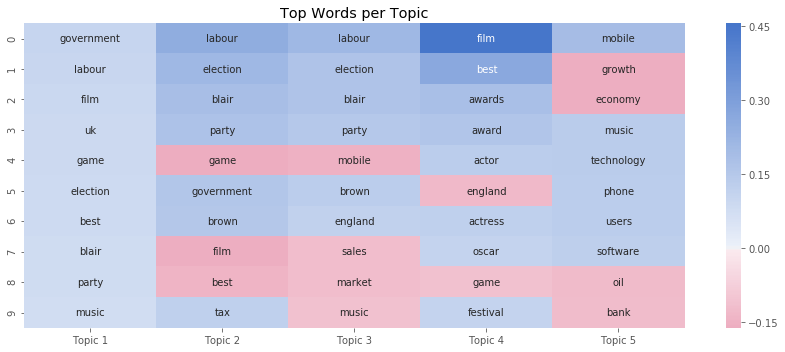

In [225]:
fig, ax = plt.subplots(figsize=(12,5))
top_words, top_vals = pd.DataFrame(), pd.DataFrame()
for topic, words_ in topics.items():
    top10 = words_.abs().nlargest(10).index
    vals = words_.loc[top10].values
    top_vals[topic] = vals
    top_words[topic] = top10.tolist()
sns.heatmap(pd.DataFrame(top_vals), 
            annot=top_words, 
            fmt = '', 
            center=0, 
            cmap=sns.diverging_palette(0, 255, sep=1, n=256), 
            ax=ax);
ax.set_title('Top Words per Topic')
fig.tight_layout()
fig.savefig('lsa_top_words', dpi=300);

#### Topics weights for test set

The topic assignments for this sample align with the average topic weights for each category illustrated below (Politics is the leftmost). They illustrate how LSI expresses the k topics as directions in a k-dimensional space (below you find a projection of the average topic assignments per category into two-dimensional space). 

Each category is clearly defined, and the test assignments match with train assignments. However, the weights are both positive and negative, making it more difficult to interpret the topics.

In [168]:
test_eval = pd.DataFrame(data=svd.transform(test_dtm), 
                         columns=topic_labels,
                         index=test_docs.Category)

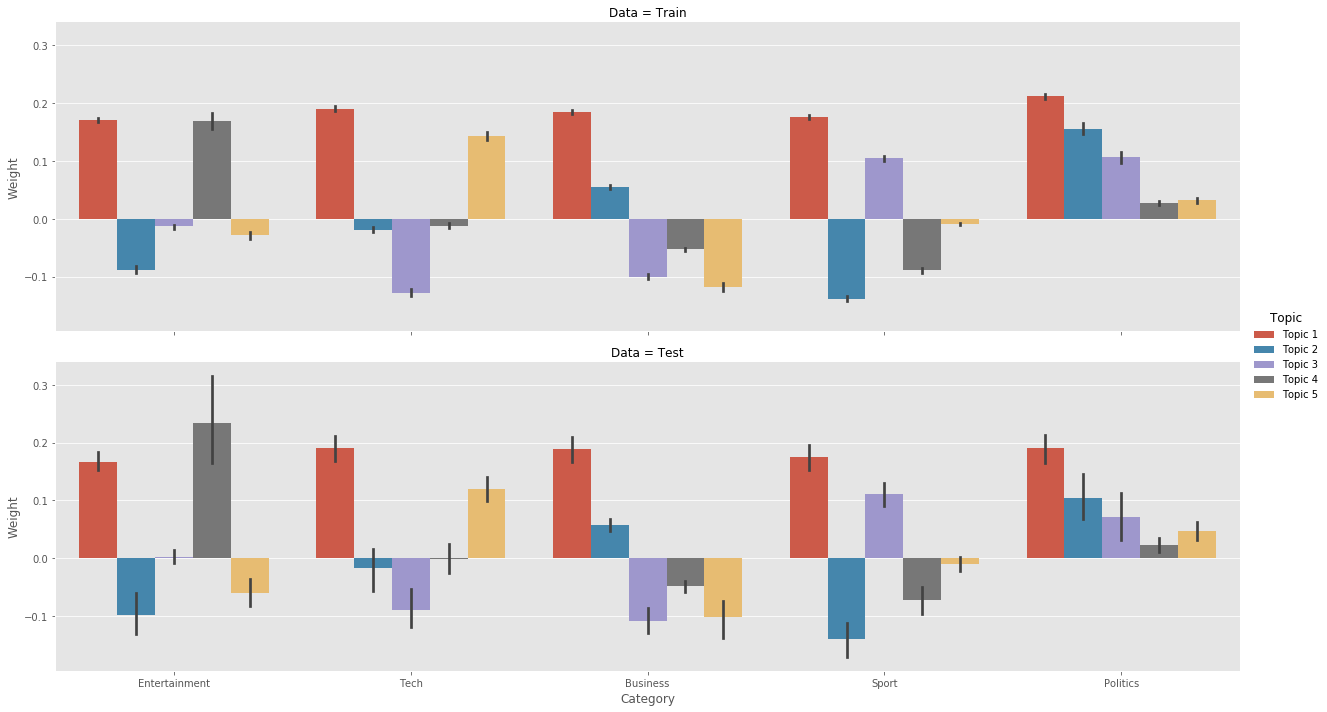

In [198]:
result = pd.melt(train_result.assign(Data='Train')
                 .append(test_eval.assign(Data='Test'))
                 .reset_index(),
                 id_vars=['Data', 'Category'],
                 var_name='Topic',
                 value_name='Weight')

g =sns.catplot(x='Category', y='Weight', hue='Topic', row='Data', kind='bar', data=result, aspect=3.5)
g.savefig('lsa_train_test', dpi=300)

### Categories in 2D

In [212]:
pca = PCA(n_components=2)
svd2d = pd.DataFrame(pca.fit_transform(train_result), columns=['PC1', 'PC2']).assign(Category=train_docs.Category)
categories_2d = svd2d.groupby('Category').mean()

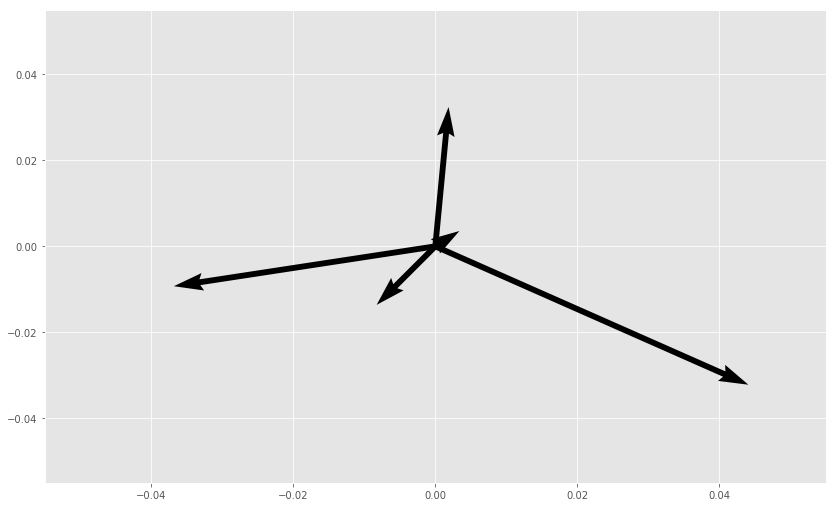

In [224]:
plt.quiver(*([0], [0]), categories_2d.PC1, categories_2d.PC2, scale=.03);

## Strenghts & Weaknesses

The benefits of LSI include the removal of noise and mitigation of the curse of dimensionality, while also capturing some semantics and performing a clustering of both documents and terms.

However, the results of LSI are difficult to interpret because topics are word vectors with both positive and negative entries. In addition, there is no underlying model that would permit the evaluation of fit and provide guidance when selecting the number of dimensions or topics.